In [3]:
!pip install jupyter pandas pyro-ppl seaborn torch rpy2

     |████████████████████████████████| 214 kB 2.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


  Using cached pytz_deprecation_shim-0.1.0.post0-py2.py3-none-any.whl (15 kB)
     |████████████████████████████████| 340 kB 66.9 MB/s eta 0:00:01
  Created wheel for rpy2: filename=rpy2-3.5.8-cp39-cp39-macosx_10_9_x86_64.whl size=250351 sha256=2ce4d50539493a8be830d966c0505e0c67fb87ce5a1bfda25bfec77c8fc9bb56
  Stored in directory: /Users/kiran/Library/Caches/pip/wheels/ed/c3/89/a83bd8df25768bd6f37ac2594ea19f9c65a17b1cf4d747c7a4
Successfully built rpy2
You should consider upgrading via the '/Users/kiran/repositories/StatisticalRethinking/venv/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist

from rethinking import MAP, precis

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R

library(tidyverse)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Easy

### 2E1. Which of the expressions below correspond to the statement: *the probability of rain on Monday?*

1. Pr(rain)
2. Pr(rain|Monday)
3. Pr(Monday|rain)
4. Pr(rain, Monday)/Pr(Monday)

Both (2) and (4). Pr(rain|Monday) = Pr(rain, Monday)/Pr(Monday)

### 2E2. Which of the following statements corresponds to the expression: Pr(Monday|rain)?

1. The probability of rain on Monday.
2. The probability of rain, given that it is Monday.
3. The probability that it is Monday, given that it is raining.
4. The probability that it is Monday and that it is raining.

(3) The probability that it is Monday, given that it is raining.

### 2E3. Which of the expressions below correspond to the statement: *the probability that it is Monday, given that it is raining?*

1. Pr(Monday|rain)
2. Pr(rain|Monday)
3. Pr(rain|Monday) Pr(Monday)
4. Pr(rain|Monday) Pr(Monday) / Pr(rain)
5. Pr(Monday|rain) Pr(rain) / Pr(Monday)

(1) and (4) are correct. Pr(Monday|rain) = Pr(Monday)Pr(rain|Monday)/Pr(rain)

### 2E4. The Bayesian statistician Bruno de Finetti (1906-1985) began his book on probability theory with the declaration: "PROBABILITY DOES NOT EXIST." The capitals appears in the original, so I imagine de Finetti wanted us to shout this statement. What he meant is that probability is a device for describing uncertainty from the perspective of an observer with limited knowledge; it has no objective reality. Discuss the globe tossing example from the chapter, in light of this statement. What does it mean to say "the probability of water is 0.7"?

In the globe-tossing example, we are unable to observe the globe itself, but rather must measure its properties by "randomly" sampling from its surface. But our tosses aren't actually random; they are governed by physical laws that we are largely unaware of when we toss the globe.

This randomization, while perhaps not truly random, removes our knowledge of where any point on the globe might land underneath our fingertips. What we determine will depend on this randomization and the number of times we sample from the surface. In this case, "the probability of water is 0.7" means, "of the times we tossed the globe, ignorant of how our tosses might influence the outcome, our right index finger landed on water 70% of the time."

## Medium

### 2M1. Recall the globe tossing model from the chapter. Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for *p*.

1. W, W, W
2. W, W, W, L
3. L, W, W, L, W, W, W

We can reuse the grid approximate posterior distribution from the R code snippet 2.3. As we are asked to assume a uniform prior for *p*, we can omit this part of the calculation.

In [9]:
%%R

grid_approx <- function(toss_sequence, num_points=100) {
    # define grid
    p_grid <- seq( from=0 , to=1 , length.out=num_points )

    # define prior
    prior <- rep( 1 , num_points )

    # compute likelihood at each value in grid
    likelihood <- dbinom(
        sum(toss_sequence == "W"),
        size=length(toss_sequence),
        prob=p_grid
    )

    # compute product of likelihood and prior
    unstd.posterior <- likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior <- unstd.posterior / sum(unstd.posterior)

    plot(p_grid,
         posterior,
         type="l",
         xlab="probability of water",
         ylab="posterior probability",
         las=1,
         lwd=2
    )

    mtext(paste(toss_sequence, collapse=" "))
}

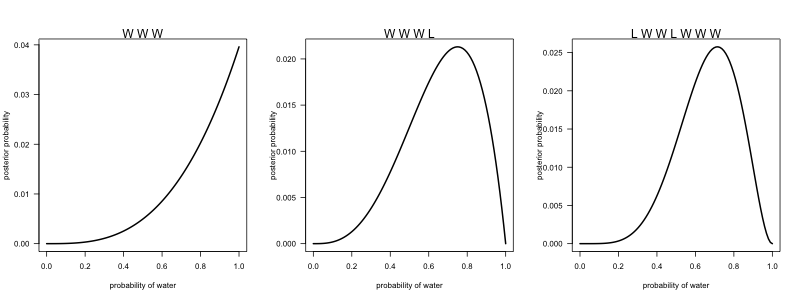

In [32]:
%%R -w 800 -h 300

options(repr.plot.width = 10, repr.plot.height = 0.75)

par(mfrow=c(1, 3))
grid_approx(c("W", "W", "W"))
grid_approx(c("W", "W", "W", "L"))
grid_approx(c("L", "W", "W", "L", "W", "W", "W"))

In [21]:
def grid_approx(toss_sequence, num_points=100):
    # define grid
    p_grid = torch.linspace(start=0, end=1, steps=num_points)

    # define prior
    prior = torch.tensor(1.).repeat(num_points)

    # compute likelihood at each value in grid
    likelihood = dist.Binomial(
        total_count=len(toss_sequence),
        probs=p_grid).log_prob(torch.tensor(toss_sequence.count("W"))).exp()

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    
    ax = sns.lineplot(x=p_grid, y=posterior, marker="o")
    ax.set(xlabel="probability of water",
           ylabel="posterior probability",
           title="100 points");

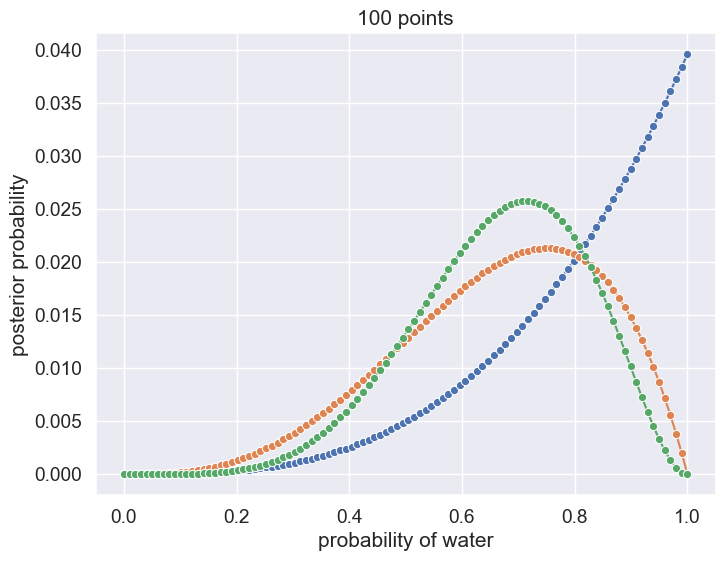

In [22]:
grid_approx(["W", "W", "W"])
grid_approx(["W", "W", "W", "L"])
grid_approx(["L", "W", "W", "L", "W", "W", "W"])

### 2M2. Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above.

In [33]:
%%R

grid_approx_new_prior <- function(toss_sequence, num_points=100, prior_constant=1) {
    # define grid
    p_grid <- seq( from=0 , to=1 , length.out=num_points )

    # define prior
    prior <- ifelse(p_grid < 0.5, 0, prior_constant)

    # compute likelihood at each value in grid
    likelihood <- dbinom(
        sum(toss_sequence == "W"),
        size=length(toss_sequence),
        prob=p_grid
    )

    # compute product of likelihood and prior
    unstd.posterior <- likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior <- unstd.posterior / sum(unstd.posterior)

    plot(p_grid,
         posterior,
         type="l",
         xlab="probability of water",
         ylab="posterior probability",
         las=1,
         lwd=2
    )

    mtext(paste(toss_sequence, collapse=" "))
}

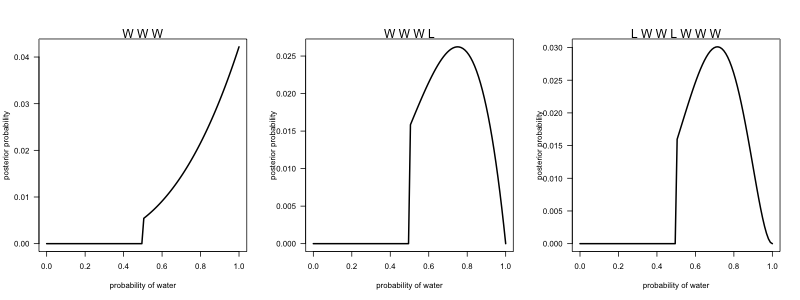

In [35]:
%%R -w 800 -h 300

par(mfrow=c(1, 3))
grid_approx_new_prior(c("W", "W", "W"))
grid_approx_new_prior(c("W", "W", "W", "L"))
grid_approx_new_prior(c("L", "W", "W", "L", "W", "W", "W"))

In [59]:
def grid_approx_new_prior(toss_sequence, num_points=100, prior_constant=1):
    # define grid
    p_grid = torch.linspace(start=0, end=1, steps=num_points)

    # define prior
    prior = torch.tensor(1.).repeat(num_points)
    prior[p_grid < 0.5] = 0

    # compute likelihood at each value in grid
    likelihood = dist.Binomial(
        total_count=len(toss_sequence),
        probs=p_grid).log_prob(torch.tensor(toss_sequence.count("W"))).exp()

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd.posterior / sum(unstd.posterior)

    ax = sns.lineplot(x=p_grid, y=posterior, marker="o")
    ax.set(xlabel="probability of water",
           ylabel="posterior probability",
           title="100 points")

In [60]:
grid_approx_new_prior(["W", "W", "W"])
grid_approx_new_prior(["W", "W", "W", "L"])
grid_approx_new_prior(["L", "W", "W", "L", "W", "W", "W"])

NameError: name 'unstd' is not defined

### 2M3. Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know which—was tossed in the air and produced a “land” observation. Assume that each globe was equally likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on seeing “land” (Pr(Earth|land)), is 0.23.

In [36]:
(0.5*0.3)/((0.5*0.3) + (0.5*1.0))

0.23076923076923075

### 2M4. Suppose you have a deck with only three cards. Each card has two sides, and each side is either black or white. One card has two black sides. The second card has one black and one white side. The third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up, but you don’t know the color of the side facing down. Show that the probability that the other side is also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This means counting up the ways that each card could produce the observed data (a black side facing up on the table).

How many ways can we produce a card with the black side up?

* card 1 (B/B): 2
* card 2 (B/W): 1
* card 3 (W/W): 0

Given that the black side is up, how many ways can we find the underside is also black?  The only way for this to happen is to have drawn the B/B card in either orientation.  Given that there are three ways to have the top face be black, the probability that the other side is also black is 2/3.

### 2M5. Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is drawn from the bag and a black side appears face up. Again calculate the probability that the other side is black.

There are now five ways to see a card with black side up, and only four ways for the opposing side to also be black. Therefore, the probability is 4/5.

### 2M6. Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that the probability the other side is black is now 0.5. Use the counting method, as before.

* B/B: 1
* B/W: 2
* W/W: 3

There are four ways to see a card with the black side up, but only two ways for the reverse side to also be black.  Therefore, the probability is 2/4 = 0.5.

### 2M7. Assume again the original card problem, with a single card showing a black side face up. Before looking at the other side, we draw another card from the bag and lay it face up on the table. The face that is shown on the new card is white. Show that the probability that the first card, the one showing a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat this like the sequence of globe tosses, counting all the ways to see each observation, for each possible first card.

* B/B -> 1/1'
* B/W -> 2/2'
* W/W -> 3/3'

Observed top face: B W
Ways to produce: 1 + 2', 1' + 2', 1 + 3, 1' + 3, 1 + 3', 1' + 3'

Observed cards: B/B W/*
Ways to produce: 1 + 2', 1 + 3, 1 + 3' + 1' + 2', 1' + 3, 1' + 3'

Probability = 6/8 = 0.75

## Hard

### 2H1. Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research.

Now suppose you are managing a captive panda breeding program. You have a new female panda of unknown species, and she has just given birth to twins. What is the probability that her next birth will also be twins?